[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/sensioai/blog/blob/master/018_perceptron_final/perceptron_final.ipynb)

# El Perceptrón - Implementación Final 

Este es el último post en la serie sobre el `Perceptrón`. En los posts de esta serie hemos implementado este modelo simple de `Machine Learning` que nos ha servido para introducir muchos conceptos importantes que seguiremos usando de ahora en adelante. Lo hemos aplicado en tareas de `regresión` y `clasificación` y también hemos ilustrado cómo funciona el algoritmo de `descenso por gradiente`, el algoritmo de optimización más utilizando hoy en día en el entrenamiento de muchos algoritmos de `Inteligencia Artificial`, como por ejemplo `redes neuronales`. En este post vamos a juntar todos los conceptos aprendidos en una implementación final que nos va a permitir solucionar todos los problemas que hemos visto hasta ahora, y muchos otros a los que te puedes enfrentar.

## Arquitectura

La primera arquitectura de `Perceptrón` que vimos es la siguiente

![](https://www.researchgate.net/profile/Shibani_Singh2/publication/321141639/figure/fig2/AS:572731935727616@1513561342872/Schematic-of-Rosenblatts-perceptron.png)

en la que tenemos una serie de entradas y una sola salida, que calculamos como el producto escalar entre el vector de pesos y las características de entrada aplicando una función de activación. Después vimos que podemos replicar esta arquitectura en paralelo para aplicaciones en las que necesitamos más de una salida, como por ejemplo clasificación en varias clases.

![](https://camo.githubusercontent.com/bcb4c2d2684739dd367e6e61d96102bb8ba28cd8/68747470733a2f2f6a6c6565776562626c6f672e66696c65732e776f726470726573732e636f6d2f323031372f30332f736f666d61782d72656772657373696f6e2e6a70673f773d36333326683d353237)

En cualquier caso, las operaciones que tenemos que llevar a cabo son siempre las mismas, sólo tendremos que utilizar diferente funciones de activación y de pérdida dependiendo de la tarea que queremos llevar a cabo.

## Funciones de Activación

Estas son las diferentes funciones de activación que hemos visto hasta ahora.

In [1]:
# lineal -> usada para regresión
def linear(x):
    return x

# step -> usada para clasificación binaria
def step(x):
    return x > 0

# sigmoid -> usada para clasificación binaria (o multiclase con varias etiquetas)
def sigmoid(x):
  return 1 / (1 + np.exp(-x))

# softmax -> usada para clasificación multiclase
def softmax(x):
    return np.exp(x) / np.exp(x).sum(axis=-1,keepdims=True)

## Funciones de Pérdida

Estas son las funciones de pérdida que hemos visto para las diferentes aplicaciones

In [61]:
# Mean Square Error -> usada para regresión (con activación lineal)
def mse(y, y_hat):
    return np.mean((y_hat - y.reshape(y_hat.shape))**2)

# Binary Cross Entropy -> usada para clasificación binaria (con sigmoid)
def bce(y, y_hat):
    return - np.mean(y.reshape(y_hat.shape)*np.log(y_hat) - (1 - y.reshape(y_hat.shape))*np.log(1 - y_hat))

# Cross Entropy (aplica softmax + cross entropy de manera estable) -> usada para clasificación multiclase
def crossentropy(y, y_hat):
    logits = y_hat[np.arange(len(y_hat)),y]
    entropy = - logits + np.log(np.sum(np.exp(y_hat),axis=-1))
    return entropy.mean()

Para poder optimizar los pesos del modelo también necesitamos sus derivadas

In [62]:
# solo si usamos activación lineal
def grad_mse(y, y_hat):
    return y_hat - y.reshape(y_hat.shape)

# solo si utilizamos sigmoid
def grad_bce(y, y_hat):
    return y_hat - y.reshape(y_hat.shape)

# solo si usamos softmax
def grad_crossentropy(y, y_hat):
    answers = np.zeros_like(y_hat)
    answers[np.arange(len(y_hat)),y] = 1    
    return (- answers + softmax(y_hat)) / y_hat.shape[0]

## Implementación final

Vamos a implementar una clase de `Python` que nos permita llevar a cabo las diferentes tareas de `regresión` y `clasificación` que hemos visto en los posts anteriores. También aprovechamos y modificamos la implementación para trabajar en modo `mini-batch`.

In [63]:
class Perceptron():
  def __init__(self, inputs, outputs, activation, loss, grad_loss):
    inputs = inputs + 1
    self.w = np.random.normal(loc=0.0, 
          scale = np.sqrt(2/(inputs+outputs)), 
          size = (inputs, outputs)) 
    self.ws = []
    self.activation = activation
    self.loss = loss
    self.grad_loss = grad_loss
    
  def __call__(self, w, x):
    return self.activation(np.dot(x, w)) 

  def fit(self, x, y, epochs, lr, batch_size=None, verbose=True, log_each=1):
    if batch_size == None:
        batch_size = len(x)
    x = np.c_[np.ones(len(x)), x]
    batches = len(x) // batch_size
    for epoch in range(1,epochs+1):
        # Mini-Batch Gradient Descent
        for b in range(batches):
            _x = x[b*batch_size:(b+1)*batch_size]
            _y = y[b*batch_size:(b+1)*batch_size]
            y_hat = self(self.w, _x)  
            #print(y_hat.shape)
            # función de pérdida
            l = self.loss(_y, y_hat)
            # derivadas
            dldh = self.grad_loss(_y, y_hat)
            dhdw = _x
            dldw = np.dot(dhdw.T, dldh)
            # actualizar pesos
            self.w = self.w - lr*dldw
        # guardar pesos para animación
        self.ws.append(self.w.copy())
        # print loss
        if verbose and not epoch % log_each:
            print(f"Epoch {epoch}/{epochs} Loss {l}")
            
  def predict(self, x):
    x = np.c_[np.ones(len(x)), x]
    return self(self.w, x)

Si bien la clase anterior nos permite llevar a cabo las diferentes tareas, podemos usarla como base para crear nuevas clases específicas para cada una de las tareas que nos interesan. De esta manera haremos más fácil su uso.

In [64]:
class LinearRegression(Perceptron):
  def __init__(self, inputs, outputs=1):
    super().__init__(inputs, outputs, linear, mse, grad_mse)

class LinearClassification(Perceptron):
  def __init__(self, inputs, outputs=1):
    super().__init__(inputs, outputs, step, mse, grad_mse)
    
class LogisticRegression(Perceptron):
  def __init__(self, inputs, outputs=1):
    super().__init__(inputs, outputs, sigmoid, bce, grad_bce)
    
class SoftmaxRegression(Perceptron):
  def __init__(self, inputs, outputs):
    # usamos activación lineal porque `crossentropy` ya incluye la softmax
    super().__init__(inputs, outputs, linear, crossentropy, grad_crossentropy)

## Regresión

Vamos a aplicar nuestra implementación para la tarea de regresión en el ejemplo que vimos en este [post](https://sensioai.com/blog/012_perceptron1). 

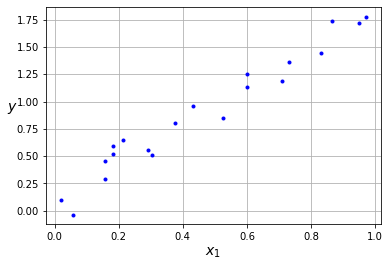

In [65]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)

x = np.random.rand(20)
y = 2*x + (np.random.rand(20)-0.5)*0.5

plt.plot(x, y, "b.")
plt.xlabel("$x_1$", fontsize=14)
plt.ylabel("$y$", rotation=0, fontsize=14)
plt.grid(True)
plt.show()

In [66]:
np.random.seed(42)

model = LinearRegression(inputs=1, outputs=1)
epochs, lr = 50, 0.05
model.fit(x.reshape(len(x),1), y, epochs, lr, log_each=10)

Epoch 10/50 Loss 0.07193289479294203
Epoch 20/50 Loss 0.025946285185912916
Epoch 30/50 Loss 0.015925370579098406
Epoch 40/50 Loss 0.013741719067994266
Epoch 50/50 Loss 0.013265880872675762


In [68]:
from matplotlib import animation, rc
rc('animation', html='html5')

def plot(i):
    ax.clear()
    ax.set_title(f"Epoch {i+1}", fontsize=14)
    ax.plot(x, y, "b.")
    x_new = np.linspace(0, 1, 100)
    x_new = x_new.reshape(len(x_new),1)
    w = model.ws[i]
    x_new_c = np.c_[np.ones(len(x_new)), x_new]
    y_pred = model(w, x_new_c)
    ax.grid(True)
    ax.plot(x_new.ravel(), y_pred.ravel())
    ax.set_xlabel("$x_1$", fontsize=14)
    ax.set_ylabel("$y$", rotation=0, fontsize=14)
    return ax

fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(111, autoscale_on=False)
anim = animation.FuncAnimation(fig, plot, frames=epochs, interval=200)
plt.close()
anim

## Clasificación Binaria

Ahora vamos a probar nuestro nuevo modelo para clasificación binaria con el dataset Iris, un dataset que ya hemos utilizado en varios posts anteriores para clasificar flores.

In [69]:
from sklearn.datasets import load_iris
import numpy as np

iris = load_iris()
X = iris.data[:, (2, 3)]  # petal length, petal width
y = (iris.target == 0).astype(np.int)

X.shape, y.shape

((150, 2), (150,))

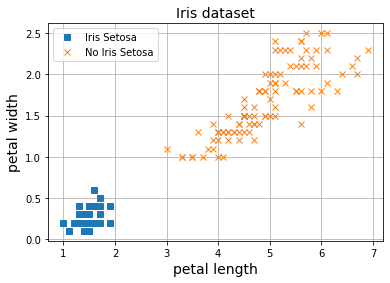

In [70]:
import matplotlib.pyplot as plt 

plt.plot(X[y==1, 0], X[y==1, 1], 's', label="Iris Setosa")
plt.plot(X[y==0, 0], X[y==0, 1], 'x', label="No Iris Setosa")
plt.grid()
plt.legend()
plt.xlabel('petal length', fontsize=14)
plt.ylabel('petal width', fontsize=14)
plt.title("Iris dataset", fontsize=14)
plt.show()

In [71]:
np.random.seed(42)

model = LogisticRegression(2)
epochs, lr = 20, 0.01
model.fit(X, y, epochs, lr)

Epoch 1/20 Loss -0.5280888851726412
Epoch 2/20 Loss 1.5519480686197276
Epoch 3/20 Loss 1.0373061713544982
Epoch 4/20 Loss 0.5787383592735013
Epoch 5/20 Loss 0.25626183960592325
Epoch 6/20 Loss 0.0806783619955926
Epoch 7/20 Loss 0.1696097212158297
Epoch 8/20 Loss 0.08229707881226088
Epoch 9/20 Loss 0.12726567794217852
Epoch 10/20 Loss 0.0838602104885461
Epoch 11/20 Loss 0.0992554258404314
Epoch 12/20 Loss 0.08157148508403225
Epoch 13/20 Loss 0.08285449156845918
Epoch 14/20 Loss 0.07577947313509739
Epoch 15/20 Loss 0.07297986291205648
Epoch 16/20 Loss 0.06904734991653973
Epoch 17/20 Loss 0.06592850166363061
Epoch 18/20 Loss 0.0629319167415559
Epoch 19/20 Loss 0.06021417415042796
Epoch 20/20 Loss 0.05770216458564948


In [72]:
from matplotlib import animation, rc
from matplotlib.colors import ListedColormap

custom_cmap = ListedColormap(['#9898ff', '#fafab0'])
rc('animation', html='html5')

fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(111, autoscale_on=False)
def plot(i, axes = [0, 5, 0, 2], label="Iris Setosa"):
    ax.clear()
    w = model.ws[i]
    tit = ax.set_title(f"Epoch {i+1}", fontsize=14)
    x0, x1 = np.meshgrid(
            np.linspace(axes[0], axes[1], 500).reshape(-1, 1),
            np.linspace(axes[2], axes[3], 200).reshape(-1, 1),
        )
    X_new = np.c_[x0.ravel(), x1.ravel()]
    X_new = np.c_[np.ones(len(X_new)), X_new] 
    y_predict = model(w, X_new)
    zz = y_predict.reshape(x0.shape)
    ax.plot(X[y==0, 0], X[y==0, 1], "bs", label=f"No {label}")
    ax.plot(X[y==1, 0], X[y==1, 1], "yo", label=label)
    ax.contourf(x0, x1, zz, cmap=custom_cmap)
    ax.set_xlabel("Petal length", fontsize=14)
    ax.set_ylabel("Petal width", fontsize=14)
    ax.legend(loc="lower right", fontsize=14)
    ax.axis(axes)
    return ax

anim = animation.FuncAnimation(fig, plot, frames=epochs, interval=200)
plt.close()
anim

## Clasificación Multiclase

Vamos a probar ahora nuestra nueva implementación para clasificar dígitos manuscritos con el dataset MNIST.

In [73]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1)
X, y = mnist["data"], mnist["target"]

X.shape, y.shape

((70000, 784), (70000,))

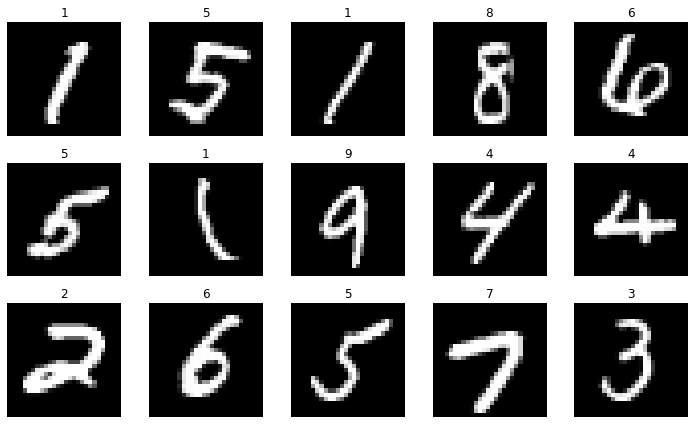

In [74]:
%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt
import random 

r, c = 3, 5
fig = plt.figure(figsize=(2*c, 2*r))
for _r in range(r):
    for _c in range(c):
        plt.subplot(r, c, _r*c + _c + 1)
        ix = random.randint(0, len(X)-1)
        img = X[ix]
        plt.imshow(img.reshape(28,28), cmap='gray')
        plt.axis("off")
        plt.title(y[ix])
plt.tight_layout()
plt.show()

In [75]:
# normalizamos los datos

X_train, X_test, y_train, y_test = X[:60000] / 255., X[60000:] / 255., y[:60000].astype(np.int), y[60000:].astype(np.int)

In [76]:
# entranamos un perceptron para clasificación en 10 clases a partir de los pixeles de cada imágen

model = SoftmaxRegression(784, 10)
epochs, lr, batch_size = 30, 1, 1000
model.fit(X_train, y_train, epochs, lr, batch_size)

Epoch 1/30 Loss 0.30428934339390656
Epoch 2/30 Loss 0.2746378717725162
Epoch 3/30 Loss 0.2613575819298228
Epoch 4/30 Loss 0.2532126643236823
Epoch 5/30 Loss 0.2474583206823898
Epoch 6/30 Loss 0.24306125058793374
Epoch 7/30 Loss 0.2395318663590322
Epoch 8/30 Loss 0.23660207020785484
Epoch 9/30 Loss 0.2341096165319252
Epoch 10/30 Loss 0.23194894694771018
Epoch 11/30 Loss 0.2300475761065344
Epoch 12/30 Loss 0.2283536411579562
Epoch 13/30 Loss 0.22682883175847482
Epoch 14/30 Loss 0.22544412477744658
Epoch 15/30 Loss 0.2241770787830016
Epoch 16/30 Loss 0.22301004486005624
Epoch 17/30 Loss 0.22192894170812066
Epoch 18/30 Loss 0.2209223926225728
Epoch 19/30 Loss 0.21998110279743088
Epoch 20/30 Loss 0.2190974010449627
Epoch 21/30 Loss 0.2182648968779717
Epoch 22/30 Loss 0.21747822028162073
Epoch 23/30 Loss 0.21673282183416717
Epoch 24/30 Loss 0.2160248175518184
Epoch 25/30 Loss 0.21535086731606937
Epoch 26/30 Loss 0.2147080788057112
Epoch 27/30 Loss 0.21409393099284188
Epoch 28/30 Loss 0.21350

Calcularemos la precisión de nuestro modelo en los datos de test. Puedes aprender sobre ésta y otras métricas en este [post](https://sensioai.com/blog/016_metricas_clasficiacion).

In [77]:
def evaluate(x):
    y = model.predict(x)
    y_probas = softmax(y)
    return np.argmax(y_probas, axis=1)

In [78]:
from sklearn.metrics import accuracy_score

y_pred = evaluate(X_test)
accuracy_score(y_test, y_pred)

0.9228

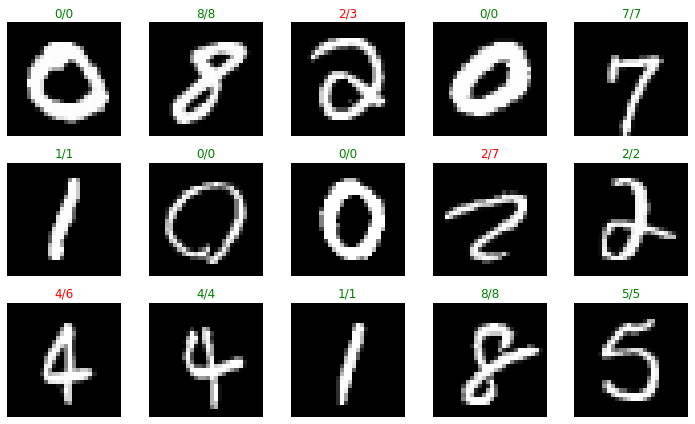

In [79]:
r, c = 3, 5
fig = plt.figure(figsize=(2*c, 2*r))
test_imgs, test_labs = [], []
for _r in range(r):
    for _c in range(c):
        plt.subplot(r, c, _r*c + _c + 1)
        ix = random.randint(0, len(X_test)-1)
        img = X_test[ix]
        y_pred = evaluate([img])[0]
        plt.imshow(img.reshape(28,28), cmap='gray')
        plt.axis("off")
        plt.title(f"{y_test[ix]}/{y_pred}", color="green" if y_test[ix] == y_pred else "red")
plt.tight_layout()
plt.show()

¡ Nuestro modelo es bastante bueno reconociendo dígitos manuscritos ! Con la matriz de confusión podemos evaluar los puntos fuertes y débiles de nuestro modelo para poder mejorarlo.

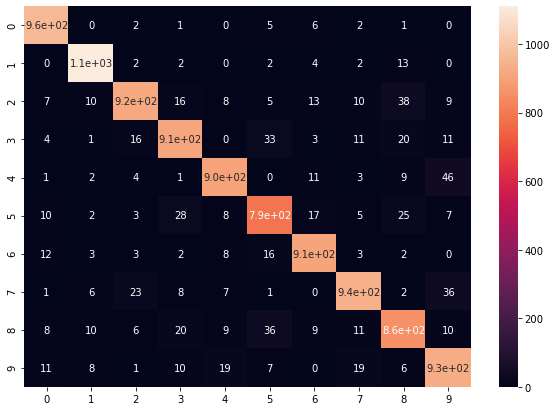

In [80]:
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sn

y_pred = evaluate(X_test)
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index = [i for i in range(0,10)], columns = [i for i in range(0,10)])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)
plt.show()

## Resumen

Con este post cerramos la serie sobre el `Perceptrón`, uno de los algoritmos de `Machine Learning` más sencillos y elemento básico de las `redes neuronales`. Aquí hemos desarrollado una implementación versátil que nos permitirá resolver multitud de problemas de `regresión` y `clasificación`. Si bien este modelo es sencillo y eficaz en muchas aplicaciones (sobretodo en aquellas que requieren de explicabilidad), tiene una gran limitación que ya hemos ilustrado anteriormente y es que cuando nuestros datos no sean fácilmente separables mediante una línea recta (lo cual ocurre prácticamente siempre) vamos a incurrir en errores que de otra forma no tendríamos si usamos modelos más complejos (modelos no lineales). Éste será nuestro foco para los próximos modelos que veremos, y cómo podemos resolver problemas más interesantes. 